In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

from utils import *

In [2]:
tf.random.set_seed(2024)

In [3]:
tukey = pd.read_pickle('data/tukey_estimates.pkl')
excess_returns = pd.read_pickle('data/exc_returns.pkl')
index_returns = pd.read_pickle('data/index_returns.pkl')
stocks_returns = pd.read_pickle('data/stocks_returns.pkl')

In [4]:
LOOK_BACK = 15
n_features = len(tukey.columns)
FORECAST_RANGE = 1

We want to start wit hthe first obsrvation of the actual test set (the whole 2018 year). However our model expect as input the previous 15 observations to perform a prediction. We need to "add" the last 15 observatin of the training set to the testing set.  

In [5]:
starting_date_test = tukey.loc[:'2017-01-02'].index[-(LOOK_BACK+1)]
starting_date_test

Timestamp('2016-12-08 00:00:00')

In [6]:
train_price, test_price = tukey.loc[:'2017-01-02'], tukey.loc[starting_date_test:]

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train_price)
scaled_test = scaler.transform(test_price)

/Users/tommasograndi/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/tommasograndi/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/tommasograndi/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/Users/tommasograndi/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a fu

In [8]:
def split_sequence(sequence, look_back, forecast_horizon):
 X, y = list(), list()
 for i in range(len(sequence)): 
   lag_end = i + look_back
   forecast_end = lag_end + forecast_horizon
   if forecast_end > len(sequence):
     break
   seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
   X.append(seq_x)
   y.append(seq_y)
 return np.array(X), np.array(y)

In [9]:
X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1001, 15, 41)
(1001, 1, 41)
(254, 15, 41)
(254, 1, 41)


## SIMPLE LSTM

In [10]:
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='relu', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')
plot_model(model=model_enc_dec, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [11]:
history = model_enc_dec.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
32/32 [==============================] - 1s 6ms/step - loss: 0.1482
Epoch 2/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0285
Epoch 3/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0131
Epoch 4/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0088
Epoch 5/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0068
Epoch 6/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0056
Epoch 7/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0047
Epoch 8/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 9/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0038
Epoch 10/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0034
Epoch 11/50
32/32 [==============================] - 0s 7ms/step - loss: 0.0030
Epoch 12/50
32/32 [==============================] - 0s 6ms/step - loss: 0.0028
Epoch 13/50
32/32 [=============================

In [12]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [13]:
def inverse_transform(y_test, yhat):
 y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
 yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
 yhat_inverse = scaler.inverse_transform(yhat_reshaped)
 y_test_inverse = scaler.inverse_transform(y_test_reshaped)
 return yhat_inverse, y_test_inverse

In [14]:
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)

In [15]:
yhat_inverse = pd.DataFrame(yhat_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)
y_test_inverse = pd.DataFrame(y_test_inverse, index=tukey.loc['2017-01-02':].index, columns=tukey.columns)

In [16]:
yhat_inverse

,VOW3 GY Equity,ENGI FP Equity,BAYN GY Equity,BNP FP Equity,PHIA NA Equity,ISP IM Equity,SAN FP Equity,MC FP Equity,ENEL IM Equity,CS FP Equity,...,OR FP Equity,BBVA SQ Equity,ASML NA Equity,SAP GY Equity,INGA NA Equity,ENI IM Equity,EOAN GY Equity,DBK GY Equity,ABI BB Equity,DTE GY Equity
2017-01-02,113.745644,12.314835,98.507797,60.970154,26.904837,2.446402,77.574326,183.430939,4.225076,24.181826,...,169.233307,6.563015,104.093987,81.784218,13.487730,15.309569,6.941269,15.919020,100.169083,16.282001
2017-01-03,113.706436,12.321634,98.833405,61.018951,26.962521,2.450577,77.629883,183.902573,4.233936,24.201920,...,169.672607,6.569729,104.403221,82.037529,13.502242,15.340243,6.952999,15.904232,100.477005,16.321037
2017-01-04,113.822235,12.345454,99.150818,61.094952,26.995932,2.455020,77.702827,184.195328,4.236551,24.224203,...,170.021637,6.582693,104.614891,82.273712,13.527743,15.345007,6.954855,15.909479,100.670639,16.337299
2017-01-05,114.335785,12.390984,99.519188,61.333904,27.027933,2.466200,77.840126,184.620117,4.245614,24.297836,...,170.382385,6.615936,104.903099,82.481842,13.587022,15.373183,6.964392,16.041605,100.735046,16.368586
2017-01-06,114.624985,12.426775,99.666702,61.473106,27.022154,2.473054,77.919403,184.679611,4.249876,24.335747,...,170.468521,6.636521,104.959045,82.543594,13.606205,15.379479,6.971845,16.130514,100.669655,16.380661
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,117.631683,12.382829,103.015388,67.314003,30.403057,2.585999,84.471344,217.537933,4.649732,26.283905,...,197.162918,6.913250,120.465073,96.275787,14.812140,16.494808,6.707601,16.454765,106.138603,17.185579
2017-12-22,117.415718,12.355783,102.783028,67.287949,30.394682,2.583252,84.387428,217.670898,4.640852,26.289928,...,197.056671,6.902208,120.393501,96.287048,14.838825,16.460775,6.671352,16.382261,106.109734,17.171976
2017-12-27,116.675026,12.334761,102.213425,66.987442,30.232908,2.569217,84.016663,216.496841,4.611536,26.143105,...,196.228455,6.855204,119.718590,95.942329,14.798741,16.310532,6.616093,16.126736,105.494011,17.058226
2017-12-28,116.393272,12.351918,102.331596,66.956223,30.144056,2.568085,83.828812,216.138992,4.604908,26.065918,...,196.134735,6.848965,119.497925,95.846497,14.808800,16.243431,6.599930,16.082834,105.182556,16.999214


In [17]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
 mse_ = tf.keras.losses.MeanSquaredError()
 mae_ = tf.keras.losses.MeanAbsoluteError()
 mape_ = tf.keras.losses.MeanAbsolutePercentageError()
 mae = mae_(y_test_inverse,yhat_inverse)
 print('mae:', mae)
 mse = mse_(y_test_inverse,yhat_inverse)
 print('mse:', mse)
 mape = mape_(y_test_inverse,yhat_inverse)
 print('mape:', mape)

In [18]:
evaluate_forecast(y_test_inverse, yhat_inverse)

mae: tf.Tensor(4.0085907, shape=(), dtype=float32)
mse: tf.Tensor(50.239216, shape=(), dtype=float32)
mape: tf.Tensor(6.865258, shape=(), dtype=float32)


In [19]:
yhat_inverse.shape, y_test_inverse.shape

((254, 41), (254, 41))

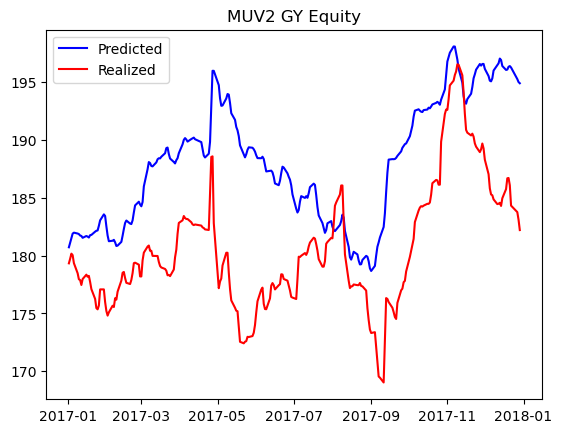

In [20]:
stock = 12

plt.plot(yhat_inverse.iloc[:,stock], color='blue', label='Predicted')
plt.plot(y_test_inverse.iloc[:,stock], color='red', label='Realized')
# plt.plot(tukey.loc['2018-01-02':,'VOW3 GY Equity'], color='green')
plt.legend()
plt.title(yhat_inverse.iloc[:,stock].name)
plt.show()

----------------

### DO NOT CONSIDER CODE BELOW

In [21]:
portfolios_LSTM = get_ranking(yhat_inverse, N = [5, 7, 10], prices=True)
 
tot_performance_LSTM, portfolio_series_LSTM = calc_portfolios(portfolios_LSTM, stocks_returns.loc[yhat_inverse.index[0]:])


tot_performance_LSTM['Index performance'] = (1 + index_returns.loc[yhat_inverse.index[0]:]).prod() - 1 
tot_performance_LSTM

{'Top5 performance': 0.4807077185311148,
 'Top7 performance': 0.42073940894266504,
 'Top10 performance': 0.3277111441821232,
 'Index performance': 0.0873696808872011}

In [31]:
# TOP 5 PORTFOLIO (best one in terms of cumulative return)
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)
portfolio_series_LSTM['Top5 series'].mean(), portfolio_series_LSTM['Top5 series'].std(), portfolio_series_LSTM['Top5 series'].mean()/portfolio_series_LSTM['Top5 series'].std() * 100

(0.002940179023940558, 0.0537965213225773, 5.465370160852064)

In [30]:
# INDEX 
# mean returns, mean std and sharpe ratio (hyp : zero risk free rate)

index_returns.loc[yhat_inverse.index[0]:].mean(), index_returns.loc[yhat_inverse.index[0]:].std(), index_returns.loc[yhat_inverse.index[0]:].mean()/index_returns.loc[yhat_inverse.index[0]:].std() * 100

(0.0003492689328041595, 0.00626025876636661, 5.5791453011593575)

In [22]:
plot_portfolios(portfolio_series_LSTM, index_returns.loc[yhat_inverse.index[0]:])

--------------